# Klasifikasi perintah lisan (audio) Bahasa Indonesia sederhana 5 kelas
Notebook ini mengimplementasikan pipeline sederhana untuk mengenali perintah suara dalam bahasa Indonesia: **"maju", "mundur", "berhenti", "kiri", "kanan"**.

- Menggunakan fitur MFCCs dan spectral statistics dan library scikit-learn `SGDClassifier`.
- Visualisasi: waveform, frequency spectrum, spectrogram, PCA (2D), dan confusion matrix.
- Dataset: **25 file audio tiap kelas**.

In [2]:
# Import Library

import os
import glob
import math
import json
from pathlib import Path
from typing import Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [3]:
# Reproducibility

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Versions:")
import sys
print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Librosa:", librosa.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)

Versions:
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 2.0.2
Librosa: 0.11.0
scikit-learn: 1.6.1


In [4]:
# Config

!unzip data.zip # unzip dataset

DATA_DIR = Path("data")
CLASSES = ["maju","mundur","berhenti","kiri","kanan"]

SR = 16000 # resample target
TRIM_SILENCE = True # menghilangkan silence/diam
TRIM_TOP_DB = 20

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Cek class count
counts = {}
for cls in CLASSES:
    files = list((DATA_DIR/cls).glob("*.wav")) + list((DATA_DIR/cls).glob("*.mp3")) + list((DATA_DIR/cls).glob("*.m4a"))
    counts[cls] = len(files)
    print(f"{cls}: {len(files)} files")

assert all(counts[c] == 25 for c in CLASSES), f"Expected: 25 file per class; mendapatkan {counts}"
print("Jumlah data benar (25 tiap kelas)")

Archive:  data.zip
   creating: data/
   creating: data/berhenti/
  inflating: data/berhenti/berhenti (1).m4a  
  inflating: data/berhenti/berhenti (10).m4a  
  inflating: data/berhenti/berhenti (11).m4a  
  inflating: data/berhenti/berhenti (12).m4a  
  inflating: data/berhenti/berhenti (13).m4a  
  inflating: data/berhenti/berhenti (14).m4a  
  inflating: data/berhenti/berhenti (15).m4a  
  inflating: data/berhenti/berhenti (16).m4a  
  inflating: data/berhenti/berhenti (17).m4a  
  inflating: data/berhenti/berhenti (18).m4a  
  inflating: data/berhenti/berhenti (19).m4a  
  inflating: data/berhenti/berhenti (2).m4a  
  inflating: data/berhenti/berhenti (20).m4a  
  inflating: data/berhenti/berhenti (21).m4a  
  inflating: data/berhenti/berhenti (22).m4a  
  inflating: data/berhenti/berhenti (23).m4a  
  inflating: data/berhenti/berhenti (24).m4a  
  inflating: data/berhenti/berhenti (25).m4a  
  inflating: data/berhenti/berhenti (3).m4a  
  inflating: data/berhenti/berhenti (4).m4a 

In [5]:
# Utils

def load_audio(path: Path, sr: int = SR, trim_silence: bool = TRIM_SILENCE, top_db: int = TRIM_TOP_DB):
    import librosa
    y, _ = librosa.load(path, sr=sr, mono=True)
    if trim_silence:
        y, _ = librosa.effects.trim(y, top_db=top_db)
    return y

def plot_waveform_spectrum_spectrogram(y: np.ndarray, sr: int = SR, title_prefix: str = "") -> None:
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Waveform
    t = np.linspace(0, len(y) / sr, num=len(y), endpoint=False)
    axs[0].plot(t, y)
    axs[0].set_title(f"{title_prefix}Waveform")
    axs[0].set_xlabel("Waktu (detik)")
    axs[0].set_ylabel("Amplitudo")

    # Frequency magnitude spectrum
    Y = np.fft.rfft(y)
    freq = np.fft.rfftfreq(len(y), d=1.0/sr)
    mag = np.abs(Y)
    axs[1].plot(freq, mag)
    axs[1].set_title(f"{title_prefix}Frequency Magnitude Spectrum (rFFT)")
    axs[1].set_xlabel("Frekuensi (Hz)")
    axs[1].set_ylabel("Magnitudo")
    axs[1].set_xlim(0, sr/2)

    # Log-power spectrogram STFT
    hop_length = 256
    win_length = 1024
    S = librosa.stft(y, n_fft=1024, hop_length=hop_length, win_length=win_length, window='hann')
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', ax=axs[2])
    axs[2].set_title(f"{title_prefix}Spectrogram (log amplitudo)")
    fig.colorbar(img, ax=axs[2], format="%+2.f dB")
    plt.tight_layout()
    plt.show()

def extract_features(y, sr: int = SR) -> np.ndarray:
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_mean, mfcc_std = np.mean(mfcc, axis=1), np.std(mfcc, axis=1)

    centroid  = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff   = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    zcr       = librosa.feature.zero_crossing_rate(y)

    feats = np.concatenate([
        mfcc_mean, mfcc_std,
        [centroid.mean(),  centroid.std()],
        [bandwidth.mean(), bandwidth.std()],
        [rolloff.mean(),   rolloff.std()],
        [zcr.mean(),       zcr.std()],
    ]).astype(np.float32)
    return feats

def features_for_file(path: Path) -> np.ndarray:
    y = load_audio(path, sr=SR)
    return extract_features(y, sr=SR)

[maju] example -> data/maju/maju (22).m4a


/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


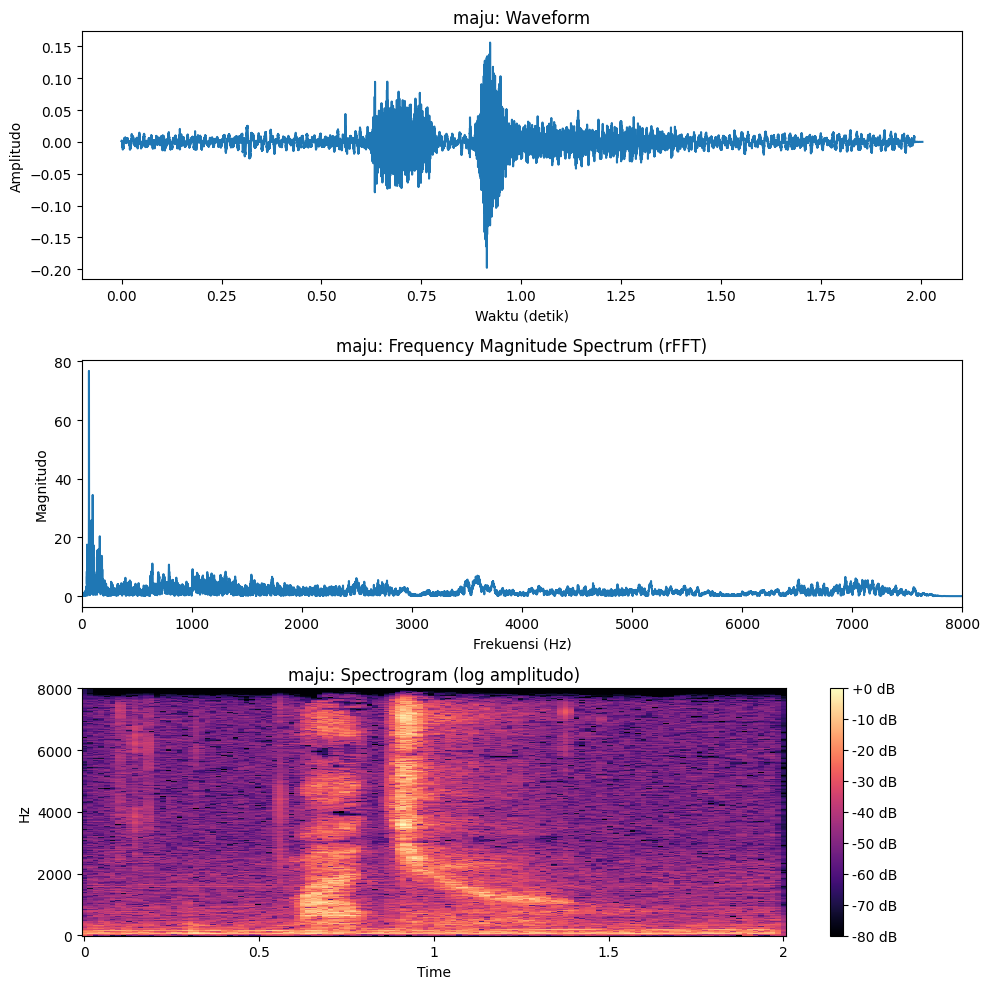

[mundur] example -> data/mundur/mundur (21).m4a


/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


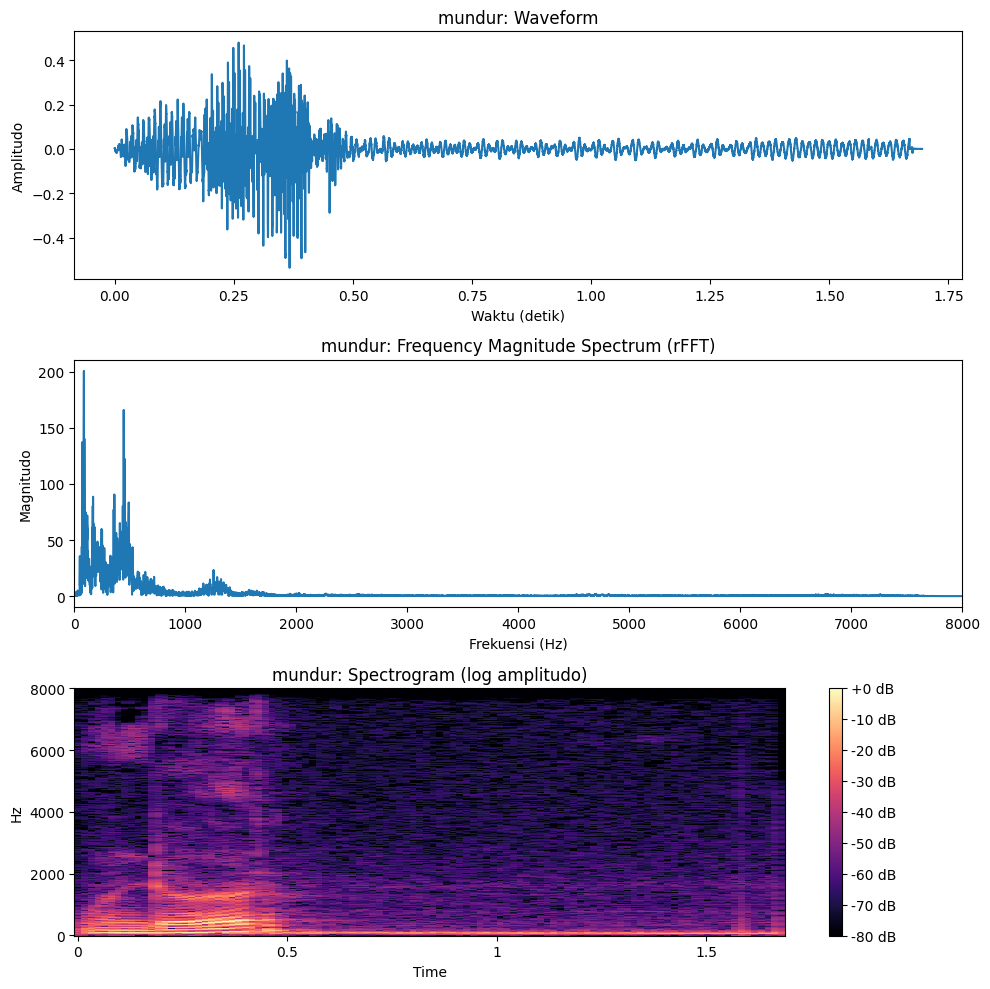

[berhenti] example -> data/berhenti/berhenti (23).m4a


/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


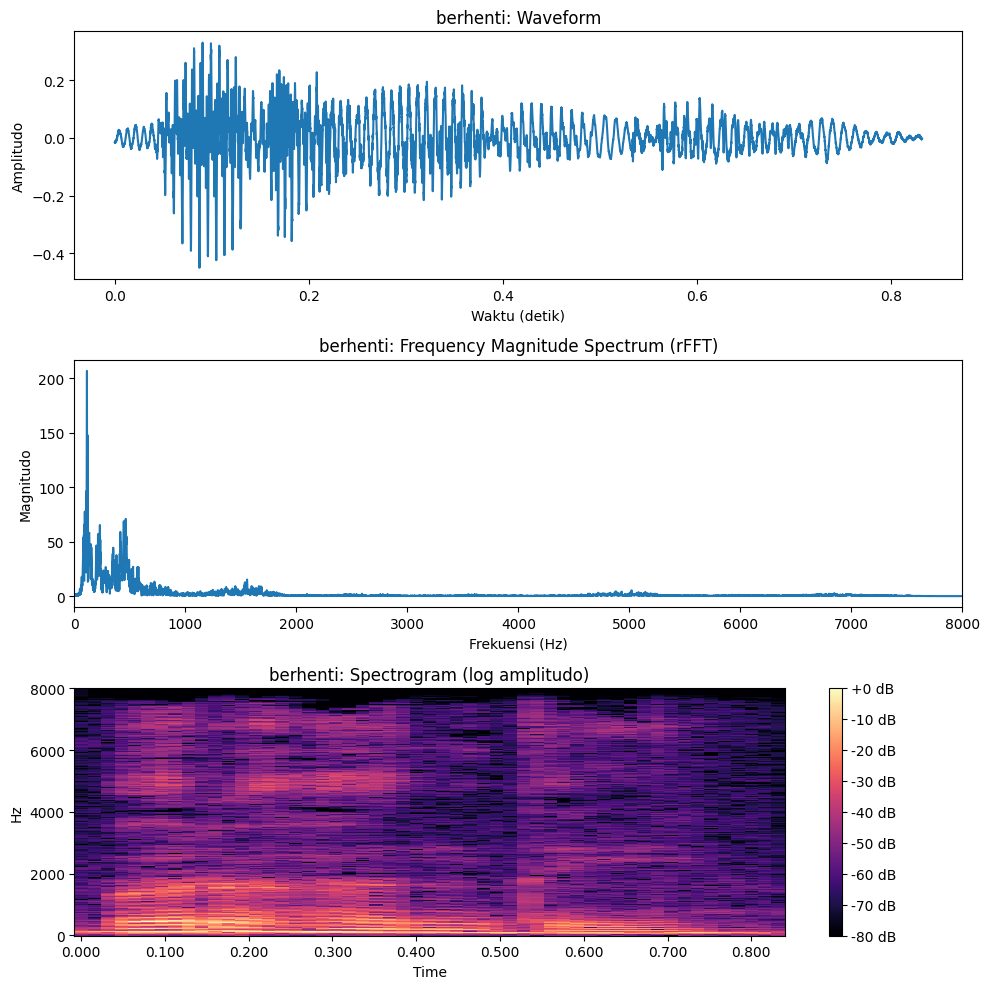

[kiri] example -> data/kiri/kiri (24).m4a


/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


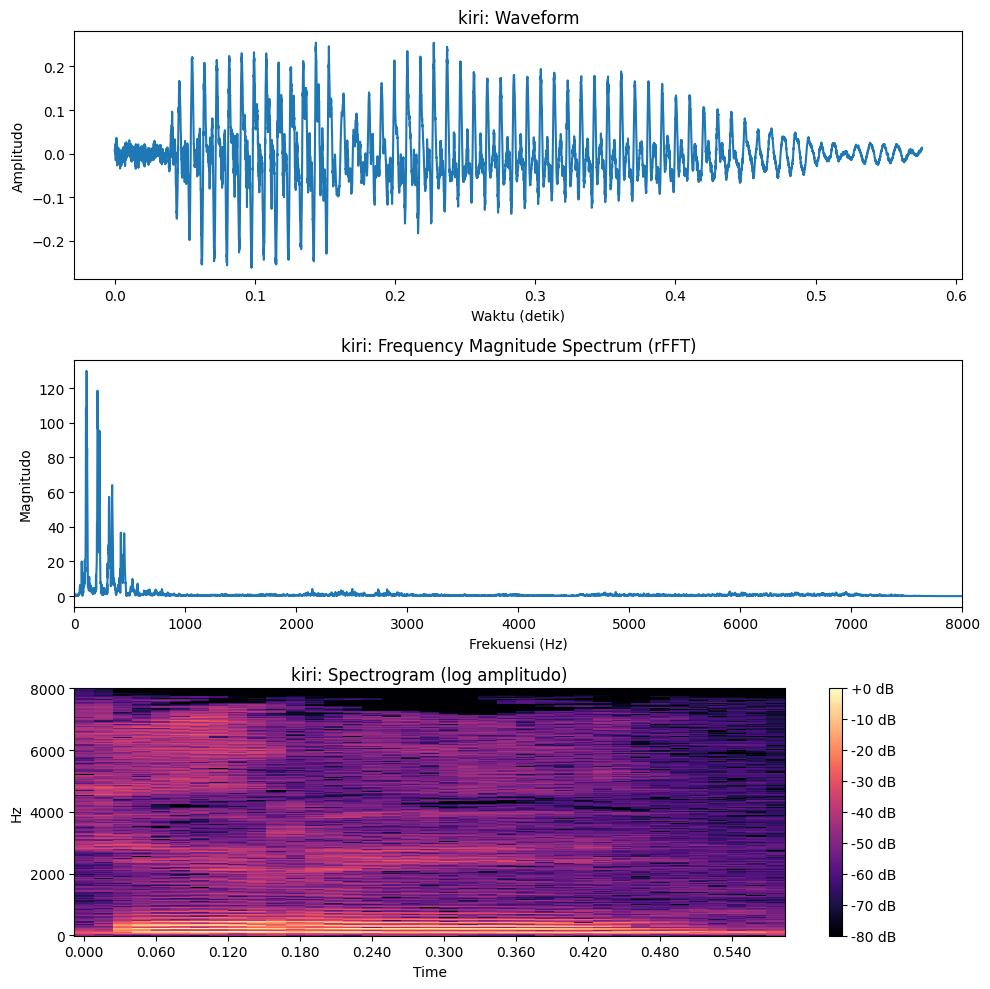

[kanan] example -> data/kanan/kanan (8).m4a


/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


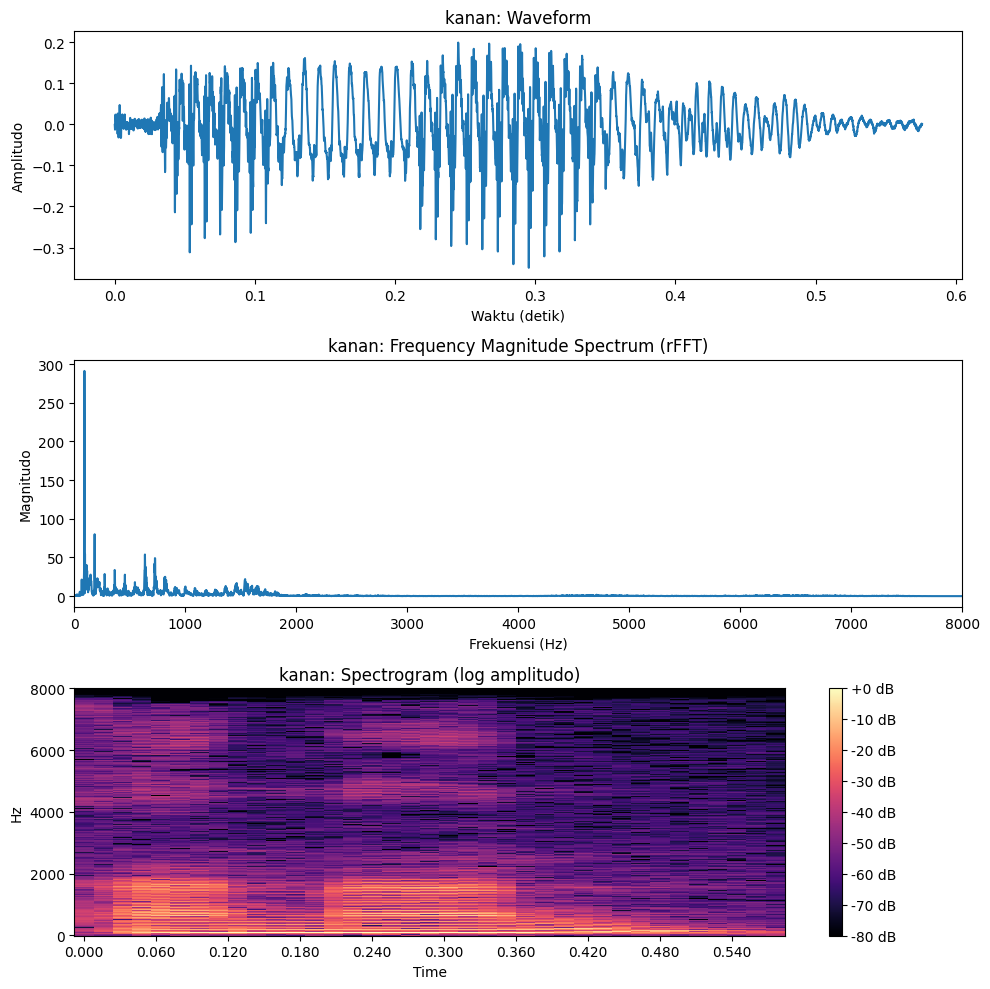

In [6]:
# Visualisasi EDA

example_files = {}
for cls in CLASSES:
    candidates = sorted(glob.glob(str(DATA_DIR / cls / "*.wav")) + glob.glob(str(DATA_DIR / cls / "*.mp3"))) + glob.glob(str(DATA_DIR / cls / "*.m4a"))
    if not candidates:
        raise FileNotFoundError(f"File audio tidak ditemukan untuk kelas '{cls}' di {DATA_DIR/cls}")
    example_files[cls] = candidates[0]  # ambil file pertama

for cls, fpath in example_files.items():
    print(f"[{cls}] example -> {fpath}")
    y = load_audio(Path(fpath), sr=SR)
    plot_waveform_spectrum_spectrogram(y, sr=SR, title_prefix=f"{cls}: ")

In [7]:
# Build Dataset (X, y)

X_list = []
y_list = []

for cls in CLASSES:
    files = sorted(glob.glob(str(DATA_DIR / cls / "*.wav")) + glob.glob(str(DATA_DIR / cls / "*.mp3"))) + glob.glob(str(DATA_DIR / cls / "*.m4a"))
    if len(files) == 0:
        raise FileNotFoundError(f"File audio tidak ditemukan untuk kelas '{cls}'. Ekspektasi: 25 file.")
    for fp in files:
        try:
            feats = features_for_file(Path(fp))
            X_list.append(feats)
            y_list.append(cls)
        except Exception as e:
            print(f"Feature extraction gagal untuk {fp}: {e}")

X = np.vstack(X_list)
y = np.array(y_list)

print("X shape:", X.shape, "(n_samples x n_features)")
print("y shape:", y.shape)
print("Class distribution:")
for cls in CLASSES:
    print(f"  {cls}: {(y == cls).sum()}")

/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages

X shape: (125, 88) (n_samples x n_features)
y shape: (125,)
Class distribution:
  maju: 25
  mundur: 25
  berhenti: 25
  kiri: 25
  kanan: 25


/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [8]:
# Train/Validation Split dan StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train:", X_train_scaled.shape, "Test:", X_test_scaled.shape)

Train: (100, 88) Test: (25, 88)


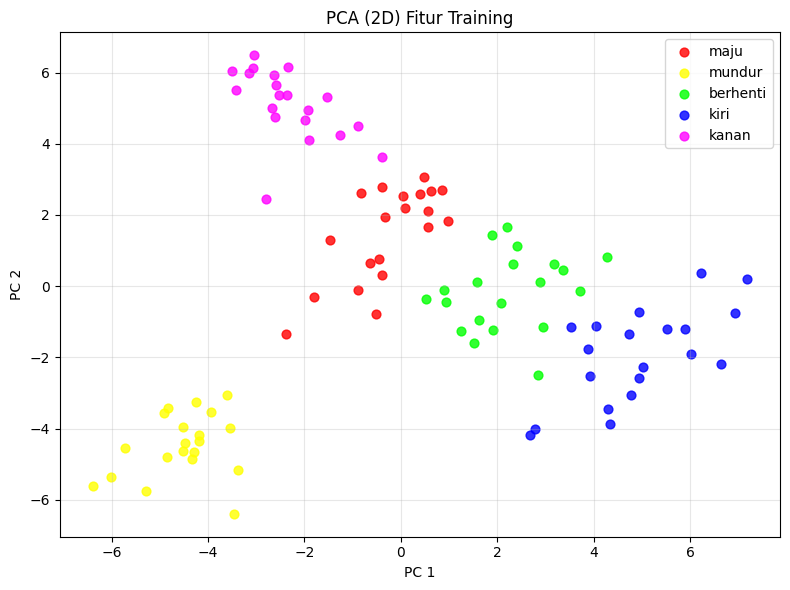

In [9]:
# PCA Training Set
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_scaled)

# Kode warna
color_map = {
    "maju": "#FF0000", # merah
    "mundur": "#FFFF00", # kuning
    "berhenti": "#00FF00", # hijau
    "kiri": "#0000FF", # biru
    "kanan": "#FF00FF" # magenta
}

plt.figure(figsize=(8, 6))
for cls in CLASSES:
    idx = (y_train == cls)
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=cls, s=40, alpha=0.8, c=color_map[cls])
plt.title("PCA (2D) Fitur Training")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Classifier

DO_GRIDSEARCH = True # hyperparameter tuning

if DO_GRIDSEARCH:
    base = SGDClassifier(
        loss="log_loss",
        penalty="elasticnet",
        class_weight="balanced",
        max_iter=5000,
        tol=1e-4,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=RANDOM_SEED,
    )
    param_grid = {
        "alpha": [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
        "l1_ratio": [0.15, 0.3, 0.5, 0.7],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    clf = GridSearchCV(
        base, param_grid=param_grid, cv=cv,
        scoring="accuracy", n_jobs=-1, verbose=1
    )
    clf.fit(X_train_scaled, y_train)
    print("Best params:", clf.best_params_)
    model = clf.best_estimator_
else:
    model = SGDClassifier(
        loss="log_loss",
        penalty="elasticnet",
        alpha=1e-3,
        l1_ratio=0.3,
        class_weight="balanced",
        max_iter=5000,
        tol=1e-4,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=RANDOM_SEED,
    )
    model.fit(X_train_scaled, y_train)

print("Model:", model)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'alpha': 0.01, 'l1_ratio': 0.15}
Model: SGDClassifier(alpha=0.01, class_weight='balanced', early_stopping=True,
              loss='log_loss', max_iter=5000, n_iter_no_change=10,
              penalty='elasticnet', random_state=42, tol=0.0001,
              validation_fraction=0.2)


Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        maju     1.0000    1.0000    1.0000         5
      mundur     1.0000    1.0000    1.0000         5
    berhenti     1.0000    1.0000    1.0000         5
        kiri     1.0000    1.0000    1.0000         5
       kanan     1.0000    1.0000    1.0000         5

    accuracy                         1.0000        25
   macro avg     1.0000    1.0000    1.0000        25
weighted avg     1.0000    1.0000    1.0000        25



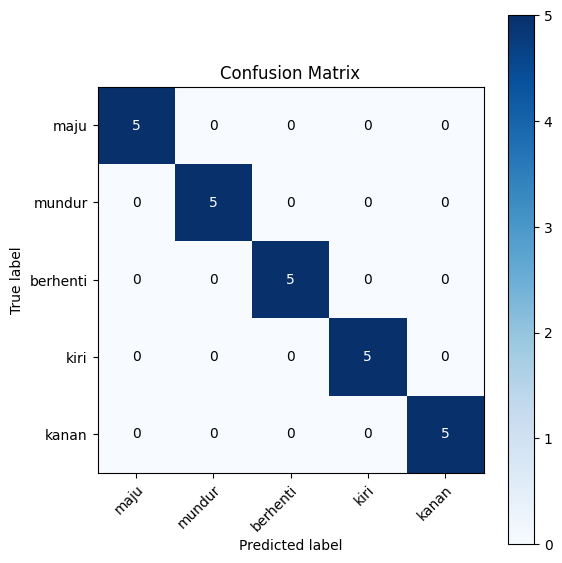

In [11]:
# Evaluasi

y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, labels=CLASSES, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=CLASSES)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=CLASSES, yticklabels=CLASSES,
       title="Confusion Matrix",
       ylabel="True label",
       xlabel="Predicted label")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [12]:
# Simpan Model

label_list = CLASSES  # urut

joblib.dump(model, ARTIFACTS_DIR / "model.joblib")
joblib.dump(scaler, ARTIFACTS_DIR / "scaler.joblib")
joblib.dump(label_list, ARTIFACTS_DIR / "labels.joblib")

feature_config = {
    "SR": SR,
    "variable_length": True,
    "trim_silence": TRIM_SILENCE,
    "trim_top_db": TRIM_TOP_DB,
    "features": {
        "mfcc_n": 40,
        "pooling": ["mean", "std"],
        "spectral": ["centroid", "bandwidth", "rolloff", "zcr"]
    }
}
joblib.dump(feature_config, ARTIFACTS_DIR / "feature_config.joblib")

print(f"Model tersimpan di: {ARTIFACTS_DIR.resolve()}")

Model tersimpan di: /content/artifacts


In [13]:
# Util untuk prediksi satu file upload

def predict_file(path: Path):

    # Load audio dan visualisasi
    y = load_audio(path, sr=SR)
    plot_waveform_spectrum_spectrogram(y, sr=SR, title_prefix=f"Test: ")

    # Feature extraction
    feats = extract_features(y, sr=SR).reshape(1, -1)
    feats_scaled = scaler.transform(feats)

    # Predict
    probs = model.predict_proba(feats_scaled)[0]
    pred_idx = np.argmax(probs)
    pred_label = model.classes_[pred_idx]

    # Build probability table
    proba_table = sorted([(cls, float(prob)) for cls, prob in zip(model.classes_, probs)],
                         key=lambda x: x[1], reverse=True)
    return pred_label, proba_table

Upload 1 file (.wav .mp3 .m4a)


Saving mundur_test.m4a to mundur_test.m4a


/tmp/ipython-input-3863606538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


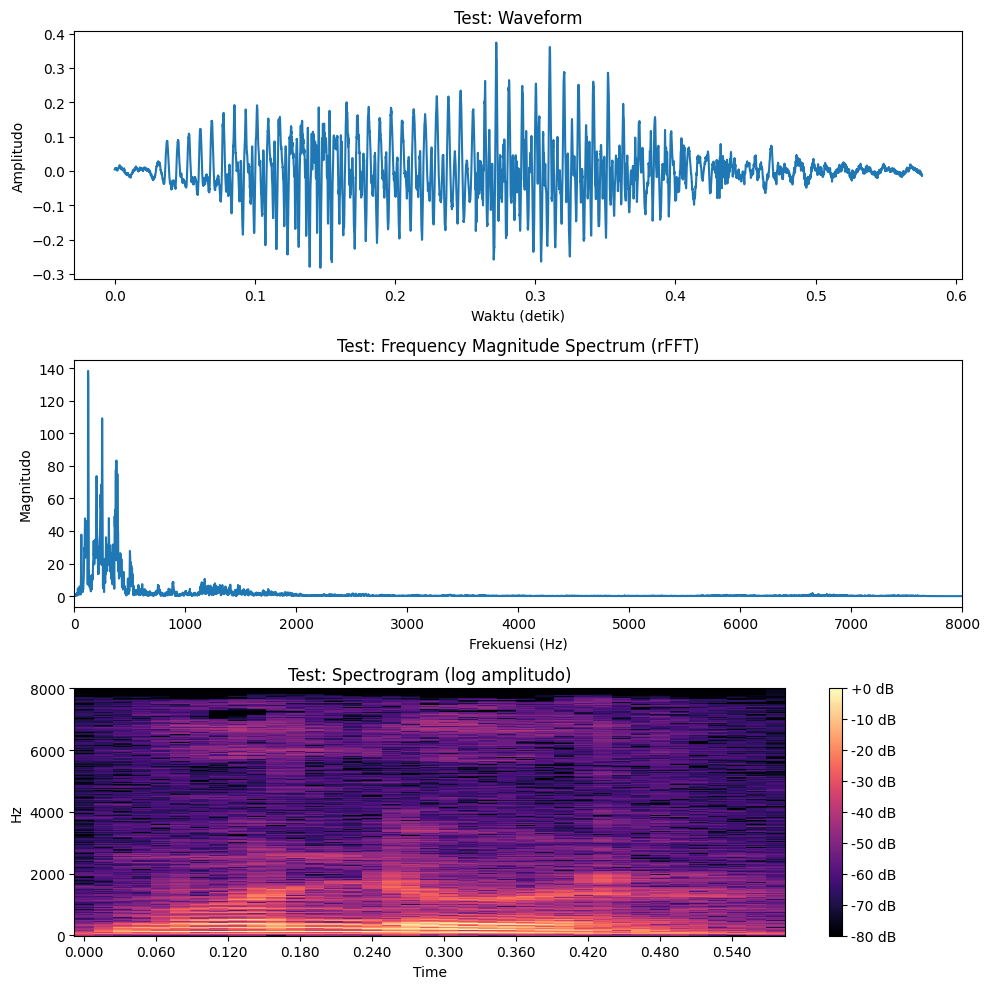


Predicted label: mundur

Probabilities (sorted):
  mundur: 1.0000
  maju: 0.0000
  kanan: 0.0000
  berhenti: 0.0000
  kiri: 0.0000


In [17]:
# Upload dan Klasifikasi (data testing)

# Untuk Google Colab
try:
    from google.colab import files  # type: ignore
    COLAB = True
except Exception:
    COLAB = False

if COLAB:
    print("Upload 1 file (.wav .mp3 .m4a)")
    up = files.upload()
    for fname, content in up.items():
        temp_path = Path(fname)
        with open(temp_path, "wb") as f:
            f.write(content)
        pred, probas = predict_file(temp_path)
        print(f"\nPredicted label: {pred}\n")
        print("Probabilities (sorted):")
        for cls, p in probas:
            print(f"  {cls}: {p:.4f}")
        temp_path.unlink(missing_ok=True)
else:
    print("Error: Kode tidak dijalankan di Google Colab.")